#### 1. Create a Local Spark Session

In [1]:
#create a spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").appName("kmeans-seed-dataset").getOrCreate()
spark

#### 2. Import libraries

In [9]:
#imports for ML pipeline and training
from pyspark.ml.feature import StandardScaler, VectorAssembler,PCA
from pyspark.ml import Pipeline
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

#### 3. Import Seeds dataset from a .csv file
This dataset is from UCI Machine Learning Repository called: Seeds Dataset: Measurements of geometrical properties of kernels belonging to three different varieties of wheat. A soft X-ray technique and GRAINS package were used to construct all seven, real-valued attributes.
link: https://archive.ics.uci.edu/ml/datasets/seeds

The real data waas a .txt file with no columns names, I transform to a .csv data with columns names to import on Spark DataSet

In [3]:
#read dataset from csv file
dataset = spark.read.csv("seeds_dataset.csv",header=True,inferSchema=True)

In [4]:
dataset.head()

Row(A=15.26, P=14.84, C=0.871, LK=5.763, WK=3.312, A_Coef=2.221, LKG=5.22, target=0)

#### 4. Create a Data pre-processing Pipeline 
#####   4.1. Create a vector from all features columns
#####   4.2. Standardize data
#####   4.3. Pass this data to a KMeans object and create the Pipeline object


In [99]:
vec_assembler = VectorAssembler(inputCols = dataset.columns[:-1], outputCol='features')

scaler = StandardScaler(inputCol=vec_assembler.getOutputCol(), outputCol="scaledFeatures", withStd=True, withMean=False)

pca = PCA(k=3,inputCol=scaler.getOutputCol(), outputCol='pcaFeatures')

kmeans = KMeans(featuresCol=pca.getOutputCol()).setK(3).setSeed(1)

pipeline = Pipeline(stages=[vec_assembler,scaler,pca,kmeans])

#### 5. Fit and Evaluate the model

##### The ClusteringEvaluator use the Silhoute metric do evaluate the model
  
Silhouette analysis can be used to study the separation distance between the resulting clusters. The silhouette plot displays a measure of how close each point in one cluster is to points in the neighboring clusters and thus provides a way to assess parameters like number of clusters visually. This measure has a range of [-1, 1].

Silhouette coefficients (as these values are referred to as) near +1 indicate that the sample is far away from the neighboring clusters. A value of 0 indicates that the sample is on or very close to the decision boundary between two neighboring clusters and negative values indicate that those samples might have been assigned to the wrong cluster. ref: https://en.wikipedia.org/wiki/Silhouette_(clustering)

Peter J. Rousseeuw (1987). "Silhouettes: a Graphical Aid to the Interpretation and Validation of Cluster Analysis". Computational and Applied Mathematics. 20: 53–65. doi:10.1016/0377-0427(87)90125-7.

In [100]:
model = pipeline.fit(dataset)
predictions = model.transform(dataset)

evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

Silhouette with squared euclidean distance = 0.6297468076319372


##### 6. Get the cluster centroids

In [101]:
centers = model.stages[3].clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[-33.36957712  10.49911306 -21.14498679]
[-28.16552722  10.34067071 -21.14674592]
[-30.30424939  11.85520074 -21.21733928]


In [108]:
predictions

DataFrame[A: double, P: double, C: double, LK: double, WK: double, A_Coef: double, LKG: double, target: int, features: vector, scaledFeatures: vector, pcaFeatures: vector, prediction: int]

In [103]:
import matplotlib.pyplot as plt

In [109]:
features = predictions.select('pcaFeatures').toPandas()
labels = predictions.select('prediction').toPandas().prediction.values
val = predictions.select('target').toPandas().target.values
x = features.pcaFeatures.apply(lambda x: x[0])
y = features.pcaFeatures.apply(lambda x: x[1])

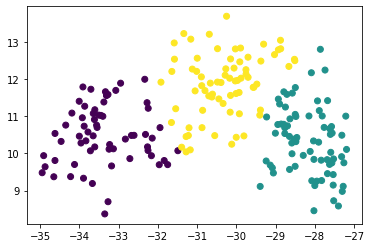

In [105]:
plt.scatter(x=x,y=y,c=labels)

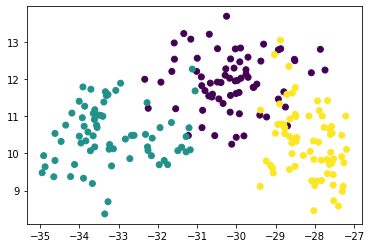

In [111]:
plt.scatter(x=x,y=y,c=val)

In [112]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(val, labels)
print(cm)

[[ 2  8 60]
 [62  0  8]
 [ 0 66  4]]
